<a href="https://colab.research.google.com/github/cl49/EPU_ML_Angers_2023/blob/main/Jour%202/6_Segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

## Training a Unet

Dans ce notebook, nous allons entraîner un Unet 2D pour la segmentation des noyaux dans le jeu de données Nuclei de Kaggle.
Il est encore possible de faire cet exercice sur le CPU, mais il vous faudra de la patience pour attendre la fin de l'entraînement. C'est pourquoi nous avons ajouté un support GPU. Veuillez basculer votre notebook sur GPU dans Modifier -> Paramètres du notebook -> Accélérateur matériel.


## The libraries

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import imageio

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

## Chargement et prétraitement des données

Pour cet exercice, nous utiliserons les données du Kaggle 2018 Data Science Bowl.
Commençons par charger les données.

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EbvS10-83JGNE2nlBxIV42izY1TOr115' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EbvS10-83JGNE2nlBxIV42izY1TOr115" -O kaggle_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq kaggle_data.zip && rm kaggle_data.zip

--2023-11-29 08:30:29--  https://docs.google.com/uc?export=download&confirm=t&id=1EbvS10-83JGNE2nlBxIV42izY1TOr115
Resolving docs.google.com (docs.google.com)... 173.194.211.139, 173.194.211.113, 173.194.211.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.211.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b6o8n3fl5hauvdjl5atog69n6decsf1f/1701246600000/17999766797462482814/*/1EbvS10-83JGNE2nlBxIV42izY1TOr115?e=download&uuid=808b5f16-7c65-4c3c-8e96-4f140c9d91e1 [following]
--2023-11-29 08:30:29--  https://doc-0k-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b6o8n3fl5hauvdjl5atog69n6decsf1f/1701246600000/17999766797462482814/*/1EbvS10-83JGNE2nlBxIV42izY1TOr115?e=download&uuid=808b5f16-7c65-4c3c-8e96-4f140c9d91e1
Resolving doc-0k-18-docs.googleusercontent.com (doc-0k-18-docs.googleusercontent.com)... 173.194.213.

Maintenant, assurez-vous que les données ont été extraites avec succès : si tout s'est bien passé, vous devriez avoir des dossiers 'nuclei_train_data' et 'nuclei_val_data' dans votre répertoire de travail. Vérifiez si c'est le cas :

In [4]:
!ls

nuclei_train_data  nuclei_val_data  sample_data


__TÂCHE__: Utilisez ls pour explorer le contenu des deux dossiers. Exécuter ls nom_de_votre_dossier devrait vous afficher ce qui est stocké dans le dossier qui vous intéresse.

Comment sont stockées les images ? Quel format ont-elles ? Et les vérités de terrain (les masques d'annotation) ? Dans quel format sont-elles stockées ?

Indice : vous pouvez utiliser la fonction suivante pour afficher les images :

In [5]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

Ce que l'on commence normalement par faire dans n'importe quelle chaîne de traitement en apprentissage automatique est d'écrire un dataset - une classe qui récupérera les échantillons d'entraînement. Une fois que vous passerez à l'utilisation de vos propres données, vous devrez comprendre comment récupérer les données vous-même. Heureusement, la plupart des fonctionnalités sont déjà fournies, mais ce que vous devez faire, c'est écrire une classe, qui fournira réellement au dataloader les échantillons d'entraînement - un Dataset.

Pour cet exercice, vous n'aurez pas encore à le faire vous-même, mais veuillez lire attentivement la classe fournie :

In [6]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'nuclei_train_data/'
TEST_PATH = 'nuclei_val_data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [7]:
def get_data(path, train=True):
  # get the total number of samples
  ids = next(os.walk(path))[1]
  X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  print('Getting and resizing train images and masks ... ')
  sys.stdout.flush()
  for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    path_new = path + id_
    # we'll use skimage library for reading file
    img = imread(path_new + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    # masks directory has multiple images - one mask per nucleus
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path_new + '/masks/'))[2]:
        mask_ = imread(path_new + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask
  if train:
    return X, Y
  else:
    return X

Maintenant, chargeons le dataset et visualisons-le en appelant notre fonction :

Dans cet exemple, nous lisons toutes les images du dossier train comme données d'entraînement (sur lesquelles le SGD est appliqué) et toutes les images du dossier de validation pour les données de test (sur lesquelles les performances sont rapportées). Les données de validation (sur lesquelles optimiser les hyper-paramètres) seront prises au hasard des données d'entraînement pendant le processus d'entraînement.

In [8]:
X_train, Y_train = get_data(TRAIN_PATH, train=True)
X_test, Y_test = get_data(TEST_PATH, train=True)

Getting and resizing train images and masks ... 


<ipython-input-7-f27cb001d273>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|          | 0/536 [00:00<?, ?it/s]<ipython-input-7-f27cb001d273>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████| 536/536 

Getting and resizing train images and masks ... 



100%|██████████| 134/134 [00:58<00:00,  2.30it/s]


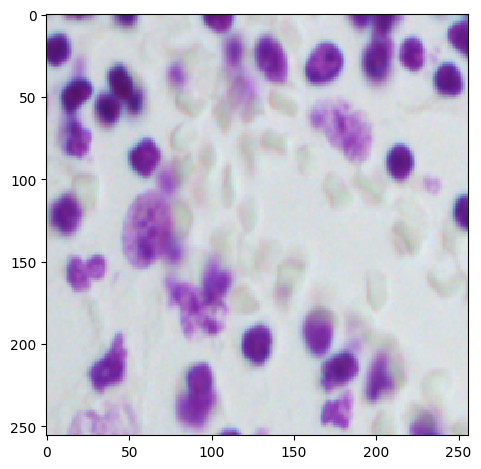

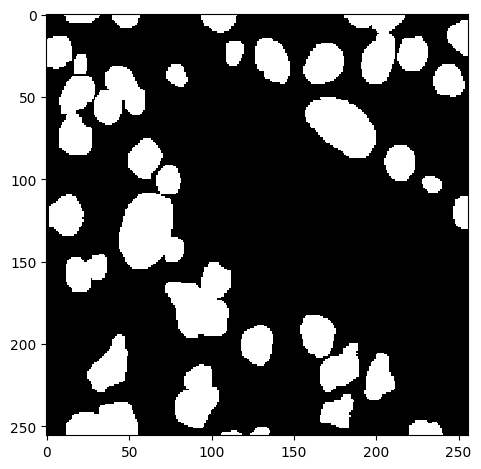

In [9]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Construction d'un modèle U-NET
Maintenant, nous devons définir l'architecture du modèle à utiliser. Cette fois, nous utiliserons un[U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) qui a prouvé son efficacité supérieure constante par rapport aux autres architectures dans la segmentation des images biologiques et médicales.

Le U-net a une structure encodeur-décodeur :

Dans la phase d'encodage, l'image d'entrée est successivement sous-échantillonnée via un max-pooling. Dans la phase de décodage, elle est à nouveau suréchantillonnée via des convolutions transposées.

De plus, il possède des connexions résiduelles, qui relient la sortie d'un encodeur au décodeur correspondant.

Notez que nous utilisons ici des convolutions valides ; les entrées des convolutions ne sont pas rembourrées et la taille spatiale de sortie après leur application diminue. Par conséquent, la taille de sortie spatiale du réseau sera plus petite que la taille d'entrée spatiale. Cela pourrait être évité en utilisant des convolutions de type same, ce qui augmenterait cependant l'effort de calcul.

Comparé au document original, nous utiliserons moins de caractéristiques (canaux) pour permettre également l'entraînement du réseau sur CPU.

In [10]:
#Each block of u-net architecture consist of two Convolution layers
# These two layers are written in a function to make our code clean
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(input_tensor)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(x)
    x = Activation("relu")(x)
    return x

In [11]:
# The u-net architecture consists of contracting and expansive paths which
# shrink and expands the inout image respectivly.
# Output image have the same size of input image
def get_unet(input_img, n_filters):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*4, kernel_size=3) #The first block of U-net
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*8, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*16, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*32, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv2d_block(p4, n_filters=n_filters*64, kernel_size=3) # last layer on encoding path

    # expansive path
    u6 = Conv2DTranspose(n_filters*32, (3, 3), strides=(2, 2), padding='same') (c5) #upsampling included
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*32, kernel_size=3)

    u7 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*16, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*8, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*4, kernel_size=3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## Loss et métriques de distance

L'étape suivante serait d'écrire une fonction de perte - une métrique qui nous indiquera à quel point nous sommes proches de la sortie souhaitée. Cette métrique devrait être différentiable, car c'est la valeur à rétropropager. Il existe [multiple losses](https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/) que nous pourrions utiliser pour la tâche de segmentation.



Nous utilisons l'entropie croisée binaire moyennée sur les pixels comme perte d'entraînement.
Cette fonction de perte est similaire à l'entropie croisée que nous avons utilisée
pour les tâches de classification précédentes.

La différence avec ces tâches est que nous prédisons un seul nombre par pixel
(la probabilité que ce pixel soit au premier plan / en arrière-plan) au lieu d'un
vecteur par image qui encode les probabilités pour plusieurs classes.

Nous utiliserons également le [Dice Coefficeint](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) pour évaluer les prédictions du réseau.
Nous pouvons l'utiliser pour la validation si nous interprétons l'ensemble $a$ comme des prédictions et $b$ comme des étiquettes. Il est souvent utilisé pour évaluer les segmentations avec un premier plan peu dense, car le dénominateur normalise par le nombre de pixels au premier plan.
Le Coefficient de Dice est étroitement lié à l'indice de Jaccard / Intersection sur Union.

In [12]:
# the coefficient takes values in [0, 1], where 0 is the worst score, 1 is the best score
# the dice coefficient of two sets represented as vectors a, b ca be computed as (2 *|a b| / (a^2 + b^2))
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

In [13]:
# Creating and Compiling the model
input_img = Input((X_train.shape[1], X_train.shape[2], 3), name='img')
model = get_unet(input_img, n_filters=4)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['img[0][0]']                 
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['activation[0][0]']          
                                                                                              

In [20]:
# Fiting the model
results = model.fit(X_train, Y_train,
                    batch_size=5, epochs=15,
                    validation_split=0.3)

Epoch 1/15
75/75 [==============================] - 4s 53ms/step - loss: 0.1645 - dice_coefficient: 0.8094 - val_loss: 0.1368 - val_dice_coefficient: 0.8245
Epoch 2/15
75/75 [==============================] - 4s 48ms/step - loss: 0.1447 - dice_coefficient: 0.8474 - val_loss: 0.1937 - val_dice_coefficient: 0.7403
Epoch 3/15
75/75 [==============================] - 4s 53ms/step - loss: 0.2714 - dice_coefficient: 0.6503 - val_loss: 0.1813 - val_dice_coefficient: 0.7108
Epoch 4/15
75/75 [==============================] - 4s 51ms/step - loss: 0.1706 - dice_coefficient: 0.7768 - val_loss: 0.1252 - val_dice_coefficient: 0.8361
Epoch 5/15
75/75 [==============================] - 4s 52ms/step - loss: 0.1504 - dice_coefficient: 0.8325 - val_loss: 0.1853 - val_dice_coefficient: 0.8046
Epoch 6/15
75/75 [==============================] - 4s 52ms/step - loss: 0.1557 - dice_coefficient: 0.8147 - val_loss: 0.1188 - val_dice_coefficient: 0.8521
Epoch 7/15
75/75 [==============================] - 4s 58m

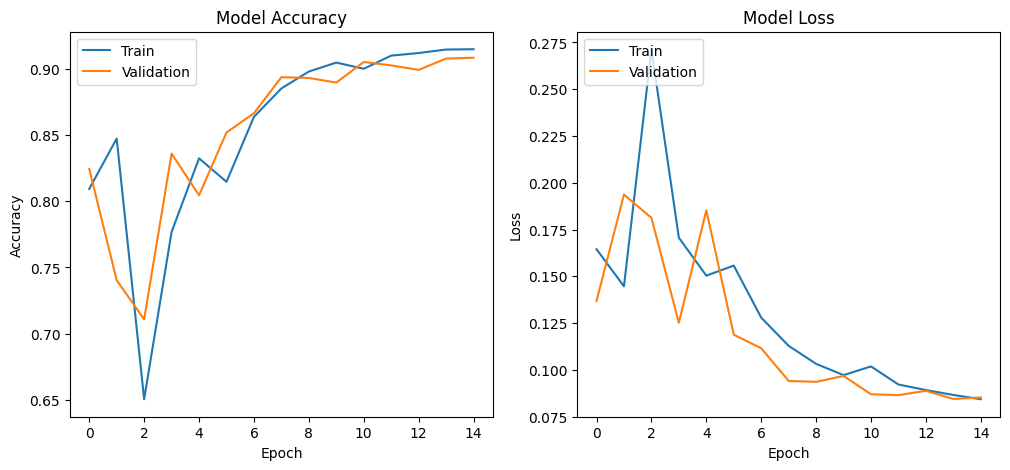

In [21]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(results.history['dice_coefficient'])
plt.plot(results.history['val_dice_coefficient'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Test du modèle et prédictions
C'est maintenant le moment d'évaluer notre modèle d'entraînement sur des données de test que le modèle n'a jamais vues auparavant. Dans Keras, nous pouvons utiliser "model.evaluate" pour évaluer le modèle d'entraînement lorsqu'il y a disponibilité de masques pour les données de test.

In [15]:
model.evaluate(X_test,Y_test)

5/5 [==============================] - 4s 299ms/step - loss: 0.1426 - dice_coefficient: 0.8345


[0.14262014627456665, 0.8344511985778809]

Dans Keras, "model.predict" est la fonction permettant de prédire la sortie (masques dans la tâche de segmentation ou étiquettes dans la tâche de classification). Ensuite, nous visualisons les résultats et comparons visuellement les masques prédits avec la vérité terrain.

In [16]:
preds_test = model.predict(X_test, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_test_t = (preds_test > 0.3).astype(np.uint8)

5/5 [==============================] - 1s 64ms/step


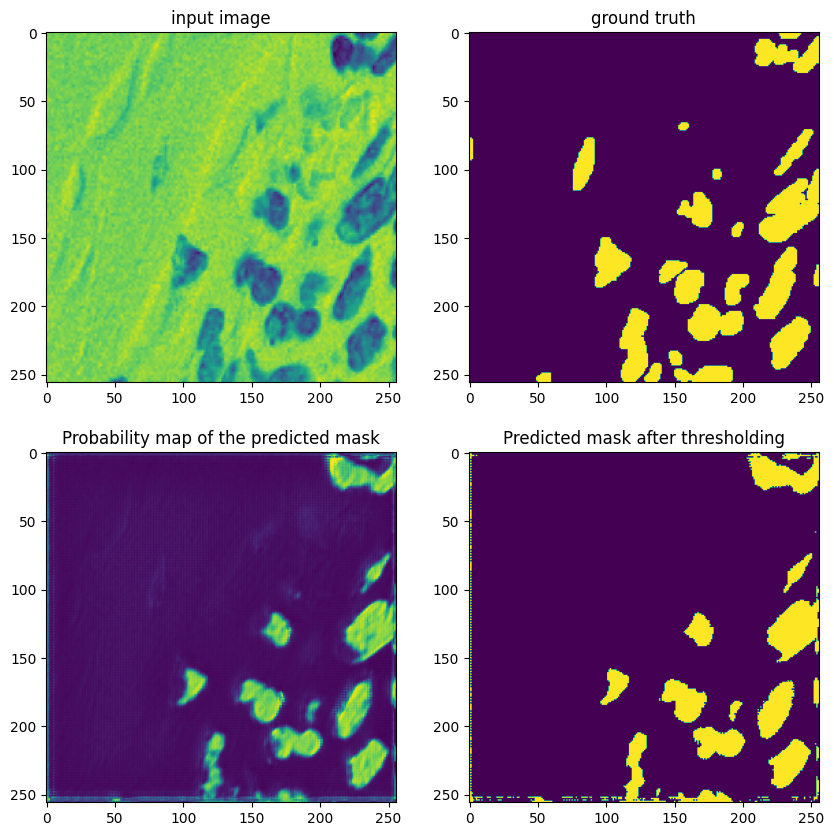

In [17]:
ix = random.randint(0, len(X_test))
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(X_test[ix,:,:,0])
plt.title("input image")
plt.subplot(222)
plt.imshow(np.squeeze(Y_test[ix, :, :, 0]))
plt.title("ground truth")
plt.subplot(223)
plt.imshow(np.squeeze(preds_test[ix, :, :, 0]))
plt.title("Probability map of the predicted mask")
plt.subplot(224)
plt.imshow(np.squeeze(preds_test_t[ix, :, :, 0]))
plt.title("Predicted mask after thresholding")
# show the plot
plt.show()

## Exercices supplémentaires

1. Implémentez et comparez au moins 2 des variantes d'architecture suivantes du U-Net :
    * utilisez [Dropout](https://keras.io/layers/core/) dans le chemin du décodeur.
    * utilisez [BatchNorm](https://keras.io/layers/normalization/) pour normaliser les entrées de couche.
    * utilisez [ELU-Activations](https://keras.io/layers/advanced-activations/) au lieu des activations ReLU.

2. Ajoutez une couche supplémentaire au modèle Unet (actuellement, il en a 4). Comparez les résultats.